In [35]:
from dotenv import load_dotenv
import os

load_dotenv()

twitter_bearer_token = os.getenv('TW_BEARER_TOKEN')

from langchain.document_loaders import TwitterTweetLoader

In [36]:
def get_users_twitter(file: str) -> list:
    with open(file, 'r') as f:
        usernames = f.read().splitlines()
    return usernames

In [37]:
loader = TwitterTweetLoader.from_bearer_token(
    oauth2_bearer_token=twitter_bearer_token,
    twitter_users=get_users_twitter('/mnt/c/Users/kozan/Desktop/Sen_Des_Proj/GPT-4-KZEngine-Signal-Interpretation/twitter-sentiment/list_users_twitter.txt'),
    number_tweets=20000,  # Default value is 100
)

In [38]:
contents = []
documents = loader.load()
for doc in documents:
    contents.append(doc.dict())
len(contents)

1967

In [39]:
import pandas as pd

df = pd.DataFrame(contents)

df['created_at'] = pd.to_datetime(df['metadata'].apply(lambda x: x['created_at']), format='%a %b %d %H:%M:%S %z %Y')
df['screen_name'] = df['metadata'].apply(lambda x: x['user_info']['screen_name'])
df = df[['screen_name', 'page_content', 'created_at']]
df = df.rename(columns={'page_content': 'text', 'screen_name': 'username'})

In [40]:
def cleaning_tweet_data( df: pd.DataFrame()):
    import re
    df_tweets = df.copy()
    if 'Unnamed: 0' in df_tweets.columns:
        df_tweets.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
    if 'source' in df_tweets.columns:
        df_tweets.drop(columns=['source', 'name', 'location', 'verified', 'description'], axis=1, inplace=True)
        

    df_tweets = df_tweets.apply(lambda x: x.astype(str).str.lower()).drop_duplicates(subset=['text', 'username'],
                                                                                        keep='first')
    
    df_tweets['text'] = df_tweets['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    df_tweets['text'] = df_tweets['text'].str.lower()
    df_tweets['text'] = df_tweets['text'].str.replace("@[a-z0-9A-Z]+", "", regex=True)
    df_tweets['text'] = df_tweets['text'].str.replace("#[a-z0-9A-Z]+", "", regex=True)

    blanks = []  # start with an empty list
    for i, created_at, text, *username in df_tweets.itertuples():
        if type(text) == str:
            if text.isspace():
                blanks.append(i)
    df_tweets.drop(blanks, inplace=True)
    # df_tweets['text'] = df_tweets['text'].str.replace(r"http\S+", "")
    # df_tweets['text'] = df_tweets['text'].str.replace(r"www.\S+", "")
    # df_tweets['text'] = df_tweets['text'].str.replace('[()!?]', ' ')
    # df_tweets['text'] = df_tweets['text'].str.replace('\[.*?\]',' ')
    # df_tweets['text'] = df_tweets['text'].str.replace("[^a-z0-9]"," ")


    df_tweets.dropna(inplace=True)


    return df_tweets

In [41]:
df['username'] = df['username'].astype(str)
df['text'] = df['text'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 0 to 1966
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   username    1967 non-null   object             
 1   text        1967 non-null   object             
 2   created_at  1967 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 46.2+ KB


In [42]:
def preprocessing_tweet_datetime(df: pd.DataFrame()) -> pd.DataFrame():
    """
    For adding datetime groups Date, Hour, Minute to existing Dataframe.
        It uses to copy of existing Dataframe
    Args:
        self (tsa) 
        df (DataFrame)

    Returns:
        DataFrame
    """
    df_temp = df.copy()
    # Fixed for some blank tweets: 'tweets'. Interesting api result delete below with function
    df_temp.drop(df_temp[df_temp.created_at == 'twitter'].index, inplace=True)
    df_temp.created_at = pd.to_datetime(df_temp.created_at)
    df_temp['Date'] = df_temp.created_at.apply(lambda x: x.date())
    df_temp['hour'] = df_temp.created_at.apply(lambda x: x.hour)
    df_temp['minute'] = df_temp.created_at.apply(lambda x: x.minute)
    return df_temp

In [43]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
def get_vader_sentiment( score):
    """
    Return to float sentiment score to with Positive, Neurtal and Negative label
    Args:
        self (tsa) 
        score (float)

    Returns: str
    """
    if score >= 0.05:
        return "Positive"
    elif 0.05 > score > -0.05:
        return "Neutral"
    elif score <= -0.05:
        return "Negative"
    return score

def get_sentiment_scores(df: pd.DataFrame()):
    df_temp = df.copy()
    df_temp['scores'] = df_temp['text'].apply(lambda review: sid.polarity_scores(review))
    df_temp['compound'] = df_temp['scores'].apply(lambda score_dict: score_dict['compound'])
    df_temp['comp_score'] = df_temp['compound'].apply(lambda score: get_vader_sentiment(score))

    return df_temp

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kozan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [44]:
import numpy as np
def add_datetime_to_col(df: pd.DataFrame()) -> None:
    df['Datetime'] = np.nan
    for i in df.index:
        if df.hour[i] < 10:
            df.loc[i, 'Datetime'] = pd.to_datetime(f'{str(df.Date[i])} 0{str(df.hour[i])}:00+00:00')
        else:
            df.loc[i, 'Datetime'] = pd.to_datetime(f'{str(df.Date[i])} {str(df.hour[i])}:00+00:00')

In [45]:
df = cleaning_tweet_data(df)
df = preprocessing_tweet_datetime(df)
df = get_sentiment_scores(df)
add_datetime_to_col(df)
df

,username,text,created_at,Date,hour,minute,scores,compound,comp_score,Datetime
0,cryptocapo_,after hours and hours of deep analysis and re...,2023-04-11 12:27:50+00:00,2023-04-11,12,27,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,2023-04-11 12:00:00+00:00
1,cryptocapo_,rt _: some thoughts.\n\ni'll continue to ignor...,2023-04-11 12:06:35+00:00,2023-04-11,12,6,"{'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'comp...",-0.3612,Negative,2023-04-11 12:00:00+00:00
2,cryptocapo_,_mc i've repeated many times that i'm short o...,2023-04-11 11:50:45+00:00,2023-04-11,11,50,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,2023-04-11 11:00:00+00:00
3,cryptocapo_,the joke would at least be funny if i shorted...,2023-04-11 11:46:53+00:00,2023-04-11,11,46,"{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'comp...",0.3716,Positive,2023-04-11 11:00:00+00:00
4,cryptocapo_,everything is based on probabilities. the mor...,2023-04-11 08:19:40+00:00,2023-04-11,8,19,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,2023-04-11 08:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...
1962,elonmusk,ad-free version if you subscribe to zuby!,2023-06-17 19:14:41+00:00,2023-06-17,19,14,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,2023-06-17 19:00:00+00:00
1963,elonmusk,rt : real talk with zuby podcast ep. 263 - \n...,2023-06-17 19:12:20+00:00,2023-06-17,19,12,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,2023-06-17 19:00:00+00:00
1964,elonmusk,this is very concerning,2023-06-17 19:10:29+00:00,2023-06-17,19,10,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,2023-06-17 19:00:00+00:00
1965,elonmusk,🤣🤣 that would definitely work for falling asl...,2023-06-17 18:36:18+00:00,2023-06-17,18,36,"{'neg': 0.142, 'neu': 0.619, 'pos': 0.239, 'co...",0.2732,Positive,2023-06-17 18:00:00+00:00


In [58]:
def get_sent_with_mean_interval(df_tweets: pd.DataFrame(), interval: str = '1h') -> pd.DataFrame():
    df_result = pd.DataFrame()
    df_result['Datetime'] = df_tweets.Datetime.unique()
    df_result['sentiment_score'] = 0
    for i, dt, com in df_result.itertuples():
        sub_df = df_tweets.copy()
        df_result.loc[i, 'sentiment_score'] = sub_df.loc[
            (sub_df.Datetime.unique()[i] == sub_df.Datetime), 'compound'].mean()
    df_result.set_index('Datetime', inplace=True)
    df_result = df_result.sort_values('Datetime')
    if interval == '1d':
        df_result = df_result.resample('D').mean().reset_index()
        df_result.set_index('Datetime', inplace=True)
        df_result = df_result.sort_values('Datetime')
    df_result = df_result.dropna(axis=0)
    return df_result

<Axes: xlabel='Datetime'>

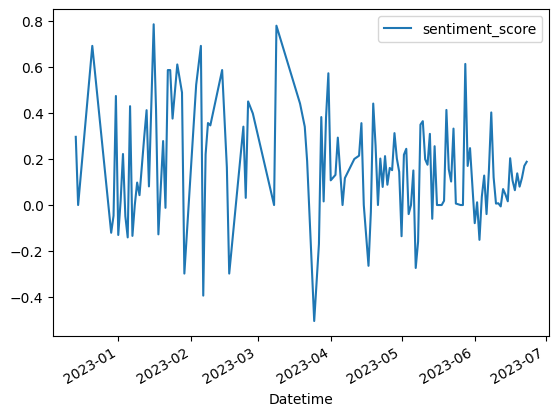

In [59]:
import matplotlib.pyplot as plt
sent_scores = get_sent_with_mean_interval(df, '1d')
sent_scores.plot()

In [53]:
sent_scores

,sentiment_score
Datetime,
2022-12-14 00:00:00+00:00,0.296000
2022-12-15 00:00:00+00:00,0.000000
2022-12-16 00:00:00+00:00,NaN
2022-12-17 00:00:00+00:00,NaN
2022-12-18 00:00:00+00:00,NaN
...,...
2023-06-19 00:00:00+00:00,0.137425
2023-06-20 00:00:00+00:00,0.079811
2023-06-21 00:00:00+00:00,0.117813
